**Pregunta 4**

In [1]:
import keras
from keras.datasets import cifar100
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

/home/difroggy/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
x_train = x_train.reshape((x_train.shape[0],3,32,32))
x_train = x_train.transpose([0, 2, 3, 1]) #only if 'tf' dim-ordering is to be used
x_test= x_test.reshape((x_test.shape[0],3,32,32))
x_test= x_test.transpose([0, 2, 3, 1])#remove if 'th' dim-ordering is to be used
y_train = keras.utils.to_categorical(y_train, num_classes=100)
y_test = keras.utils.to_categorical(y_test, num_classes=100)
x_train = x_train/255.0
x_test = x_test/255.0

Parte a)

Librerías son importadas.

In [3]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,Activation,BatchNormalization
from keras.optimizers import SGD,Adam
from timeit import default_timer as timer
import numpy as np

Luego se define el modelo.

In [4]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:],activation='relu'))
model.add(Conv2D(32, (3, 3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
__________

Se define una función para visualizar la pérdida y precisión durante el entrenamiento del modelo.

In [5]:
import matplotlib.pyplot as plt
def resumenGrafico(history):
    if ('acc' in history.history):
        fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
        ax = axes.flatten()
        ax[0].plot(history.history['loss'])
        ax[0].plot(history.history['val_loss'])
        ax[0].set_title('Perdida del modelo')
        ax[0].set_ylabel('Perdida')
        ax[0].set_xlabel('Epoch')
        ax[0].legend(['Train', 'Val'], loc='upper left')
        ax[1].plot(history.history['acc'])
        ax[1].plot(history.history['val_acc'])
        ax[1].set_title('Precision del modelo')
        ax[1].set_ylabel('Precision')
        ax[1].set_xlabel('Epoch')
        ax[1].legend(['Train', 'Val'], loc='upper left')
    else:
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Perdida del modelo')
        plt.ylabel('Perdida')
        plt.xlabel('Epoch')
        plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Entonces se entrena el modelo y luego se muestran los gráficos correspondientes.

In [6]:
optimizer_ = SGD(lr=0.01,momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=optimizer_, metrics=['accuracy'])
start = timer()
historia1=model.fit(x_train, y_train, batch_size=128,epochs=15,verbose=0, validation_data=(x_test,y_test))
end = timer()
print("Tiempo de ejecución: {} seg".format(end - start))

Tiempo de ejecución: 181.72081060300115 seg


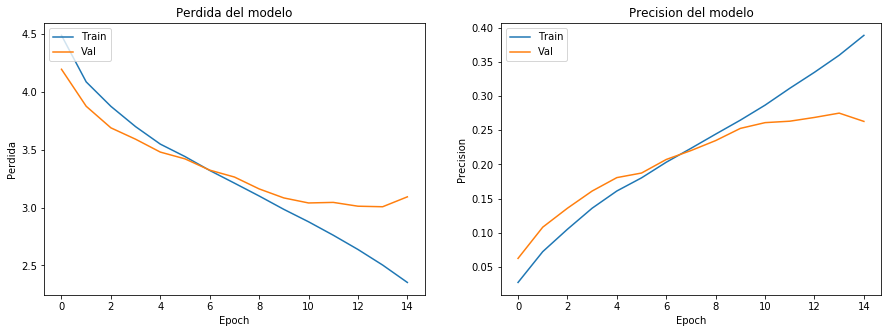

In [7]:
resumenGrafico(historia1)

Como se puede observar, la red neuronal es propensa a overfitting tras aproximadamente 10 epochs, lo que indica que se deben hacer uso de regularizadores.

Parte b)

Se exploran 7 distintas variaciones para la ubicación del dropout.
* Después de la primera tanda de capas convolucionales.
* Después de la segunda tanda de capas convolucionales.
* Después de la primer pooling.
* Después del segundo.
* Tras ambas capas convolucionales.
* Tras ambos poolings.
* En todas las anteriores.

Se procede a entrenar todos estos modelos.

In [16]:
historias=[]
for i in range(7):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:],activation='relu'))
    model.add(Conv2D(32, (3, 3),padding='same',activation='relu'))
    if(i==0 or i==6 or i==4):
        model.add(Dropout(0.25))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if(i==2 or i==6 or i==5):
        model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
    model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
    if(i==1 or i==6 or i==4):
        model.add(Dropout(0.25))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if(i==3 or i==6 or i==5):
        model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(100))
    model.add(Activation('softmax'))
    optimizer_ = SGD(lr=0.01,momentum=0.9)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer_, metrics=['accuracy'])
    start = timer()
    history=model.fit(x_train, y_train, batch_size=128,epochs=15,verbose=0, validation_data=(x_test,y_test))
    historias.append(history)
    end = timer()
    print("Tiempo de ejecución: {} seg".format(end - start))

Tiempo de ejecución: 194.0694785830001 seg
Tiempo de ejecución: 181.8685716710006 seg
Tiempo de ejecución: 174.33081272300115 seg
Tiempo de ejecución: 171.35494282800028 seg
Tiempo de ejecución: 211.0561264049993 seg
Tiempo de ejecución: 179.4229742919997 seg
Tiempo de ejecución: 223.84632589399916 seg


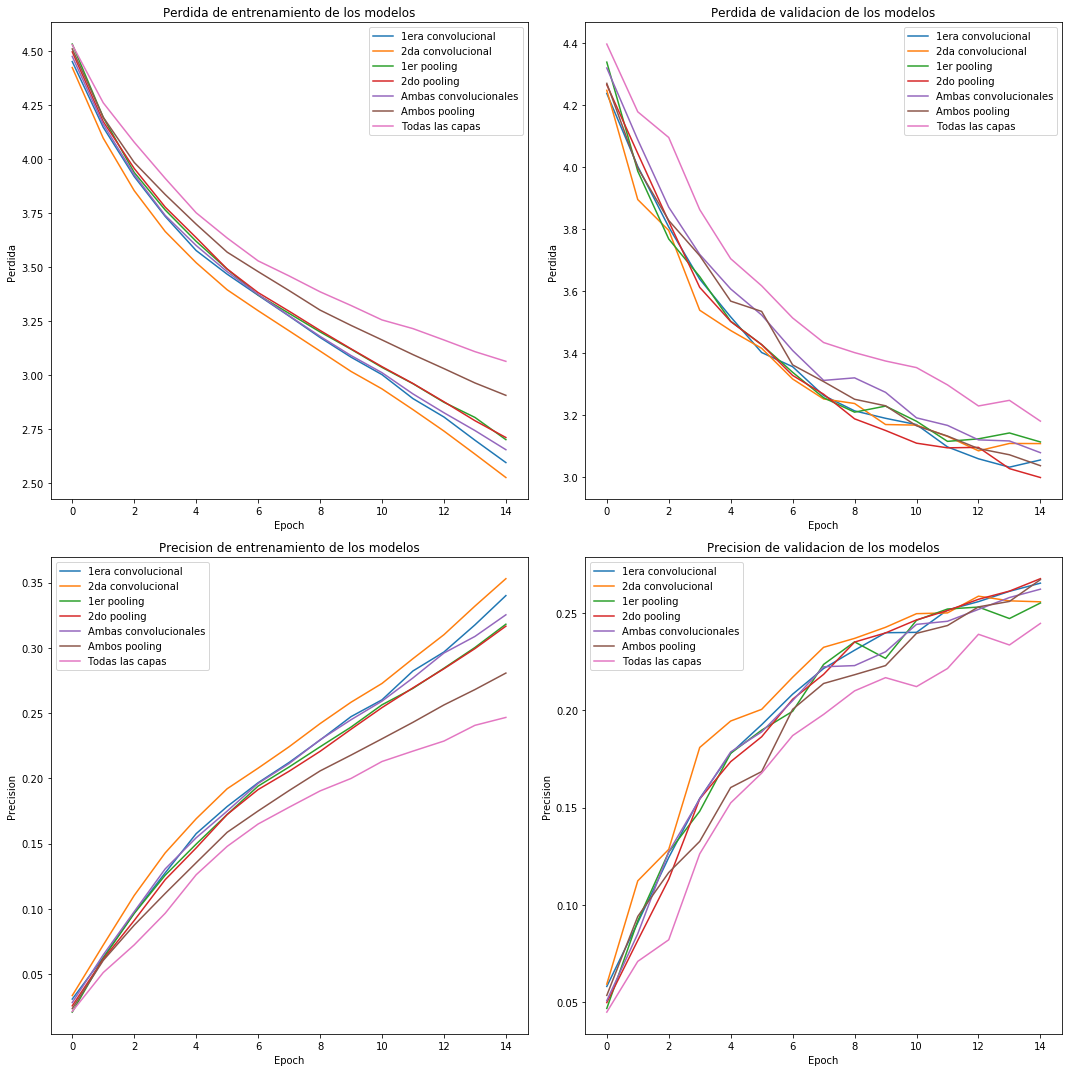

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
ax = axes.flatten()
leg=['1era convolucional','2da convolucional','1er pooling','2do pooling','Ambas convolucionales','Ambos pooling','Todas las capas']
for i in range(7):
    ax[0].plot(historias[i].history['loss'])
    ax[1].plot(historias[i].history['val_loss'])
    ax[2].plot(historias[i].history['acc'])
    ax[3].plot(historias[i].history['val_acc'])
ax[0].set_title('Perdida de entrenamiento de los modelos')
ax[0].set_ylabel('Perdida')
ax[0].set_xlabel('Epoch')
ax[0].legend(leg, loc='upper right')
ax[1].set_title('Perdida de validacion de los modelos')
ax[1].set_ylabel('Perdida')
ax[1].set_xlabel('Epoch')
ax[1].legend(leg, loc='upper right')
ax[2].set_title('Precision de entrenamiento de los modelos')
ax[2].set_ylabel('Precision')
ax[2].set_xlabel('Epoch')
ax[2].legend(leg, loc='upper left')
ax[3].set_title('Precision de validacion de los modelos')
ax[3].set_ylabel('Precision')
ax[3].set_xlabel('Epoch')
ax[3].legend(leg, loc='upper left')
plt.tight_layout()
plt.show()

El que mejor se desempeña es el que utiliza dropout directamente bajo la segunda tanda de capas convolucionales.

Se podría argumentar que dado que dropout ignora de manera aleatoria ciertas neuronas, introducirlo en las primeras capas dificulta el aprendizaje (pues estas son las más cercanas al input).

Por otro lado, repetir el dropout significa disponer de menos información a lo largo de toda la red, lo que perjudica el aprendizaje. Esto se puede ver en el modelo donde se aplicó dropout a todas las capas consideradas, el cuál tiene el peor desempeño de todos.

Además, aquellos modelos que ocuparon dropout tras pooling mostraron el peor desempeño respecto a los que no. Esto podría ponerse en paralelo a la analogía de las capas más sensibles; cómo el pooling toma la señal más prominente de un conjunto de neuronas, la capa siguiente es más sensible a aprendizaje y por lo tanto ignorar algunas neuronas termina produciendo una pérdida de información que entorpece a la red neuronal.

Parte c)

Primero se definen las funciones de activación de los autoencoders, al igual que la función de pérdida.

In [9]:
loss_='binary_crossentropy'
activation_1='relu'
activation_2='relu'
decoder_activation='sigmoid'
decoder_activation2='sigmoid'

In [8]:
from keras.layers import Input
from keras.models import Model

Los autoencoders son entrenados.

In [11]:
hidden_layer1=64
hidden_layer2=128

In [13]:
input_img = Input(shape=x_train.shape[1:])
encoded1 = Conv2D(hidden_layer1, (3, 3),activation=activation_1,padding='same')(input_img)
decoded1 = Conv2D(3, (3, 3), activation=decoder_activation, padding='same')(encoded1)
autoencoder1 = Model(input_img, decoded1)
autoencoder1.compile(optimizer='adam', loss=loss_)
autoencoder1.summary()
start=timer()
autoencoder1.fit(x_train, x_train, epochs=15, batch_size=128,validation_data=(x_test, x_test),verbose=0)
end = timer()
print("Tiempo de ejecución autoencoder1: {} seg".format(end - start))
autoencoder1.save('autoencoder_layer1.h5')
###BUILD AUTOENCODER2
encoded1 = autoencoder1.layers[1](autoencoder1.input)
#AUTOENCODER2
encoded2 = Conv2D(hidden_layer2,(3, 3), activation=activation_2, padding='same')(encoded1) 
decoded2 = Conv2D(hidden_layer1,(3, 3), activation=decoder_activation2,padding='same')(encoded2) 
#finish AUTOENCODER2
decoded1 = autoencoder1.layers[-1](decoded2)
autoencoder2 = Model(autoencoder1.input, decoded1) #all model
#autoencoder1 set fixed
autoencoder2.layers[1].trainable=False
autoencoder2.layers[-1].trainable=False
autoencoder2.compile(optimizer='adam', loss=loss_)
autoencoder2.summary()
start=timer()
autoencoder2.fit(x_train, x_train, epochs=10, batch_size=128,validation_data=(x_test, x_test),verbose=0)
end = timer()
print("Tiempo de ejecución autoencoder2: {} seg".format(end - start))
autoencoder2.save('autoencoder_layer2.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 3)         1731      
Total params: 3,523
Trainable params: 3,523
Non-trainable params: 0
_________________________________________________________________
Tiempo de ejecución autoencoder1: 139.196041514002 seg
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 64)        1792      
___________________

Luego se entrena el modelo indicado en el enunciado.

In [14]:
model = Sequential()
model.add(Conv2D(hidden_layer1,(3, 3),padding='same',activation=activation_1,input_shape=x_train.shape[1:]))
model.layers[-1].set_weights(autoencoder1.layers[1].get_weights())
model.add(Conv2D(hidden_layer2, (3, 3),padding='same',activation=activation_2))
model.layers[-1].set_weights(autoencoder2.layers[2].get_weights())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Activation('softmax'))
optimizer_ = keras.optimizers.SGD(lr=0.01,momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=optimizer_, metrics=['accuracy'])
start=timer()
historia2=model.fit(x_train, y_train, batch_size=128,epochs=15,verbose=0, validation_data=(x_test, y_test))
end = timer()
print("Tiempo de ejecución: {} seg".format(end - start))

Tiempo de ejecución: 348.55553956800213 seg


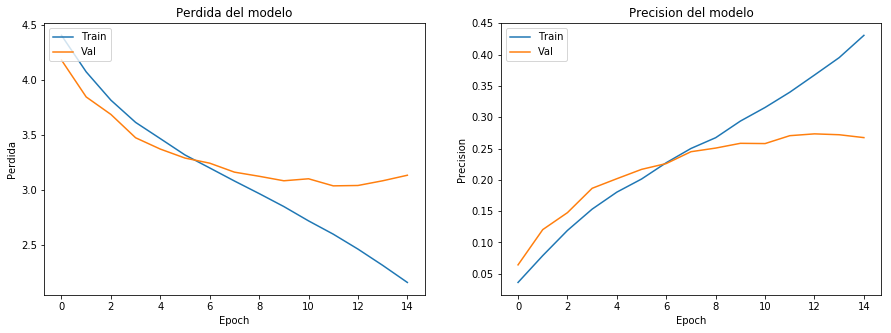

In [15]:
resumenGrafico(historia2)

En contraste con la red original, este modelo sufre de overfitting aún más rápido, ahora a los 6 epochs.

In [16]:
historias=[]
historias.append(historia1)
historias.append(historia2)

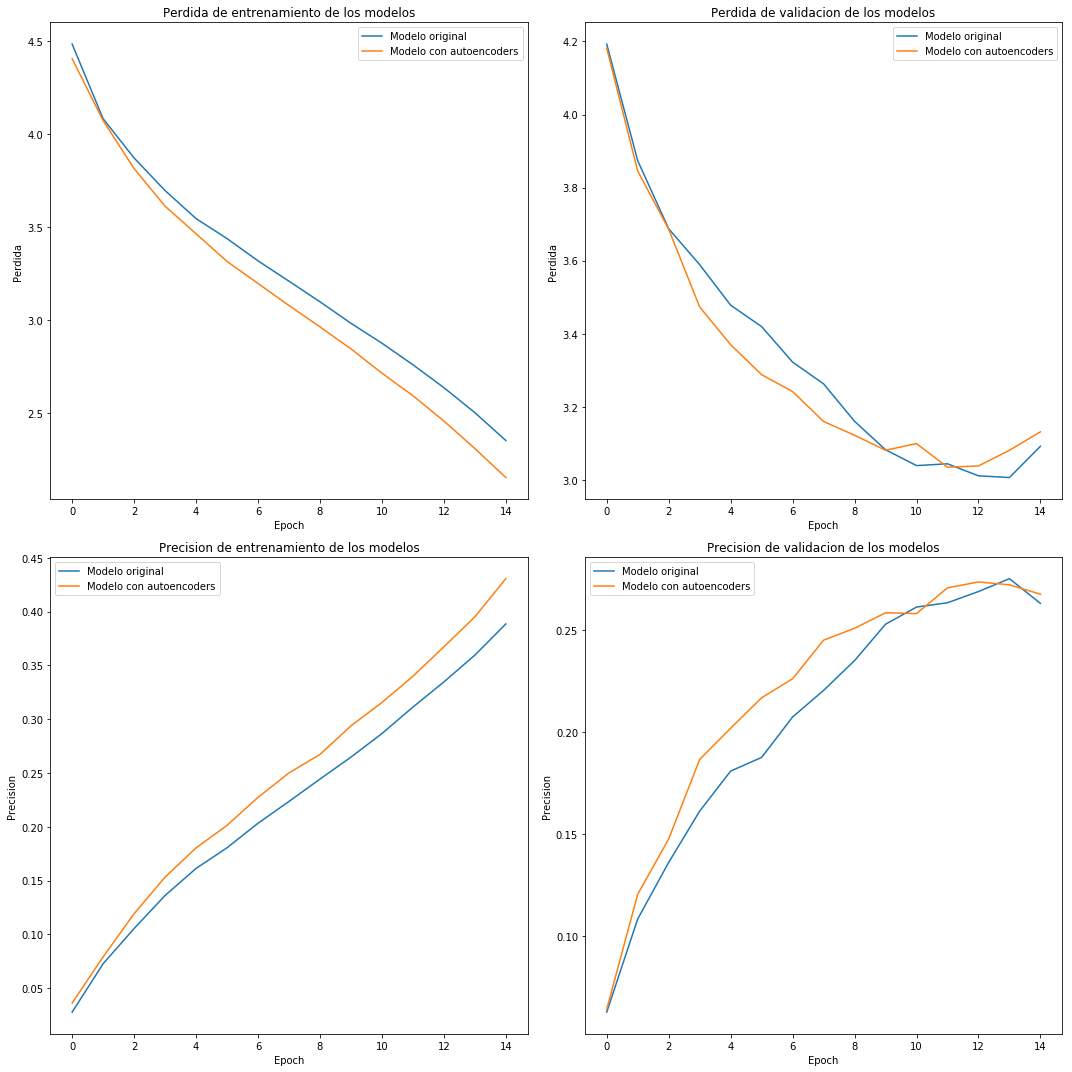

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
ax = axes.flatten()
leg=['Modelo original','Modelo con autoencoders']
for i in range(2):
    ax[0].plot(historias[i].history['loss'][0:15])
    ax[1].plot(historias[i].history['val_loss'][0:15])
    ax[2].plot(historias[i].history['acc'][0:15])
    ax[3].plot(historias[i].history['val_acc'][0:15])
ax[0].set_title('Perdida de entrenamiento de los modelos')
ax[0].set_ylabel('Perdida')
ax[0].set_xlabel('Epoch')
ax[0].legend(leg, loc='upper right')
ax[1].set_title('Perdida de validacion de los modelos')
ax[1].set_ylabel('Perdida')
ax[1].set_xlabel('Epoch')
ax[1].legend(leg, loc='upper right')
ax[2].set_title('Precision de entrenamiento de los modelos')
ax[2].set_ylabel('Precision')
ax[2].set_xlabel('Epoch')
ax[2].legend(leg, loc='upper left')
ax[3].set_title('Precision de validacion de los modelos')
ax[3].set_ylabel('Precision')
ax[3].set_xlabel('Epoch')
ax[3].legend(leg, loc='upper left')
plt.tight_layout()
plt.show()

Parte d)

Se carga el modelo indicado y luego se presentan las capas.

In [10]:
from keras.applications import VGG16
#LOAD PRETRAINED MODEL 
input_tensor=Input(shape=x_train.shape[1:])
modelVGG = VGG16(weights='imagenet', include_top=False,input_tensor=input_tensor )
features_train = modelVGG.predict(x_train)
features_test = modelVGG.predict(x_test)
modelVGG.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

Parte e)

In [47]:
epochs_=10

In [48]:
model = Sequential()
model.add(Flatten(input_shape=features_train.shape[1:]))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Activation('softmax'))
optimizer_ = keras.optimizers.SGD(lr=0.01,momentum=0.9)
model.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
start=timer()
hist=model.fit(features_train, y_train,epochs=epochs_, batch_size=128,verbose=0,validation_data=(features_test,y_test))
end = timer()
print("Tiempo de ejecución: {} seg".format(end - start))

Tiempo de ejecución: 11.937091241999951 seg


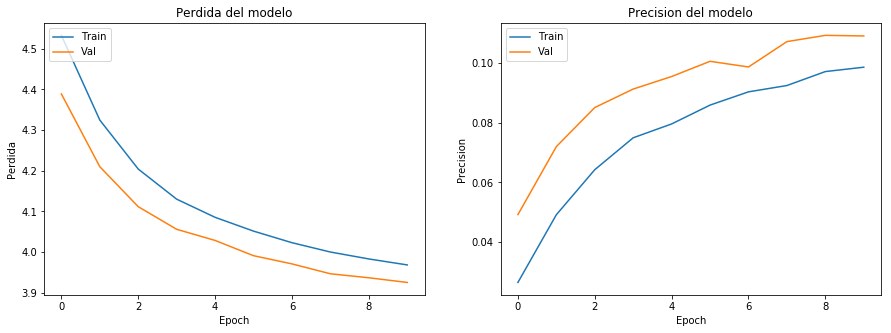

In [49]:
resumenGrafico(hist)

In [50]:
epochs_=15

In [51]:
model = Sequential()
model.add(Flatten(input_shape=features_train.shape[1:]))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Activation('softmax'))
optimizer_ = keras.optimizers.SGD(lr=0.01,momentum=0.9)
model.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
start=timer()
hist0=model.fit(features_train, y_train,epochs=epochs_, batch_size=128,verbose=0,validation_data=(features_test,y_test))
end = timer()
print("Tiempo de ejecución: {} seg".format(end - start))

Tiempo de ejecución: 17.079375022000022 seg


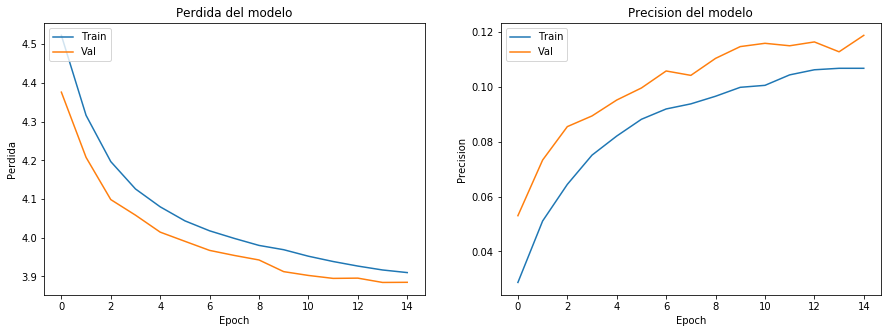

In [52]:
resumenGrafico(hist0)

Parte f)

In [53]:
model = Sequential()
model.add(Flatten(input_shape=features_train.shape[1:]))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Activation('softmax'))
model.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_15 (Flatten)         (None, 512)               0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 512)               2048      
_________________________________________________________________
dense_29 (Dense)             (None, 1024)              525312    
_________________________________________________________________
batch_normalization_9 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_15 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 100)               102500    
_________________________________________________________________
activation_15 (Activation)   (None, 100)               0         
Total para

In [54]:
start=timer()
histo=model.fit(features_train, y_train,epochs=epochs_, batch_size=128,verbose=0,validation_data=(features_test,y_test))
end = timer()
print("Tiempo de ejecución: {} seg".format(end - start))

Tiempo de ejecución: 24.002983189000588 seg


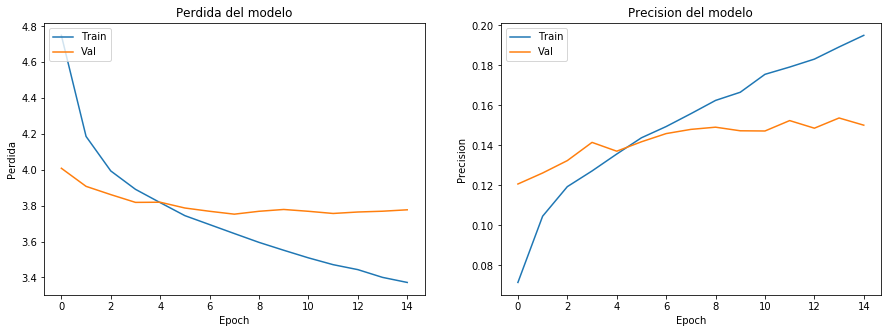

In [55]:
resumenGrafico(histo)

Se modifica el modelo del enunciado, pues se indica que se agrega solamente una capa de Batch Normalization después de la capa densa.

In [56]:
model = Sequential()
model.add(Flatten(input_shape=features_train.shape[1:]))
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Activation('softmax'))
model.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])

In [57]:
start=timer()
hist2=model.fit(features_train, y_train,epochs=epochs_, batch_size=128,verbose=0,validation_data=(features_test,y_test))
end = timer()
print("Tiempo de ejecución: {} seg".format(end - start))

Tiempo de ejecución: 21.484053287999814 seg


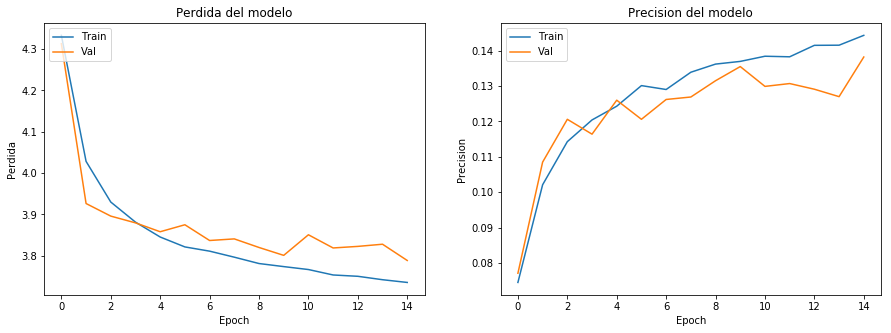

In [58]:
resumenGrafico(hist2)

In [59]:
historias=[]
historias.append(hist0)
historias.append(hist2)

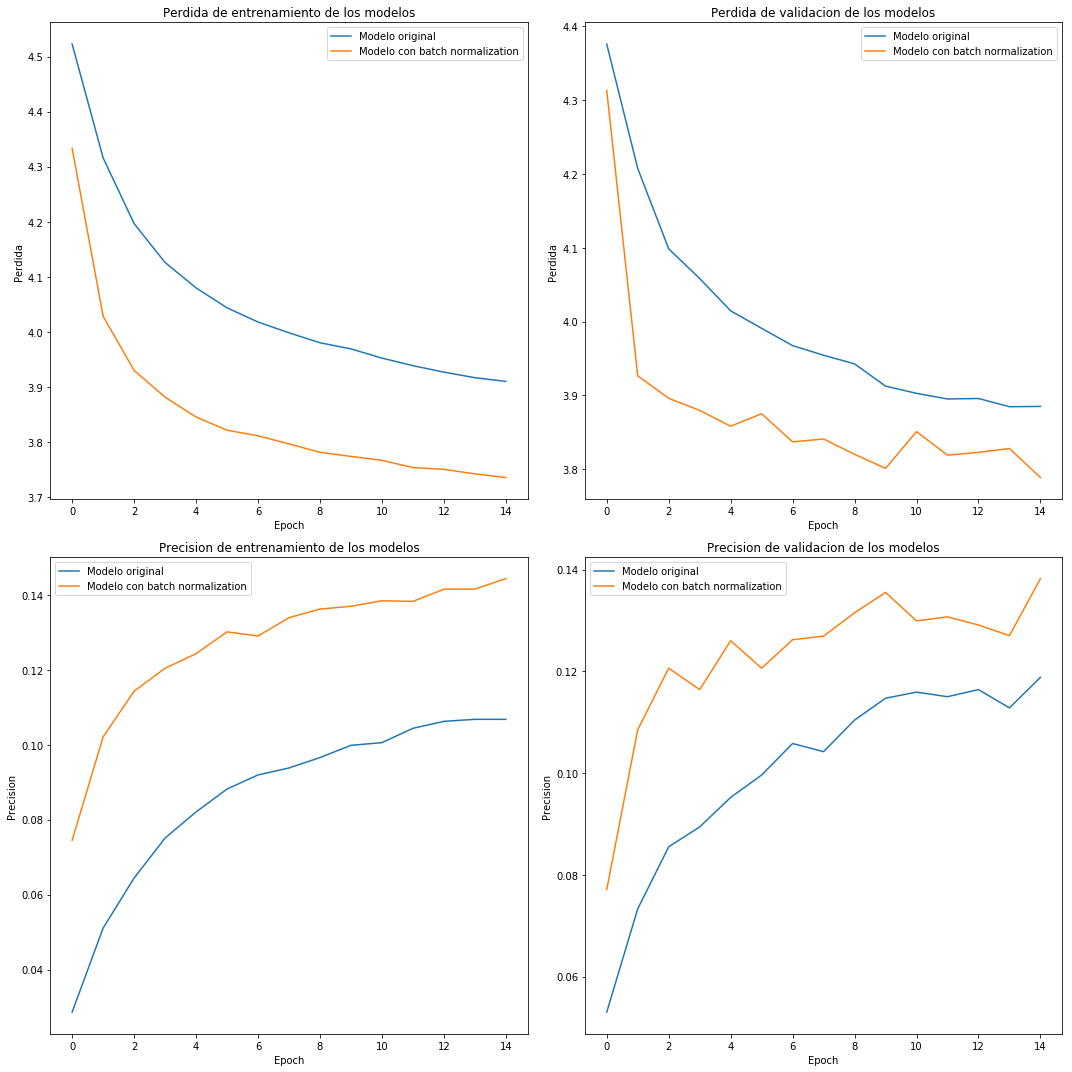

In [60]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
ax = axes.flatten()
leg=['Modelo original','Modelo con batch normalization']
for i in range(2):
    ax[0].plot(historias[i].history['loss'])
    ax[1].plot(historias[i].history['val_loss'])
    ax[2].plot(historias[i].history['acc'])
    ax[3].plot(historias[i].history['val_acc'])
ax[0].set_title('Perdida de entrenamiento de los modelos')
ax[0].set_ylabel('Perdida')
ax[0].set_xlabel('Epoch')
ax[0].legend(leg, loc='upper right')
ax[1].set_title('Perdida de validacion de los modelos')
ax[1].set_ylabel('Perdida')
ax[1].set_xlabel('Epoch')
ax[1].legend(leg, loc='upper right')
ax[2].set_title('Precision de entrenamiento de los modelos')
ax[2].set_ylabel('Precision')
ax[2].set_xlabel('Epoch')
ax[2].legend(leg, loc='upper left')
ax[3].set_title('Precision de validacion de los modelos')
ax[3].set_ylabel('Precision')
ax[3].set_xlabel('Epoch')
ax[3].legend(leg, loc='upper left')
plt.tight_layout()
plt.show()

Parte g)

In [67]:
#LOAD PRETRAINED MODEL 
input_tensor=Input(shape=x_train.shape[1:])
modelVGG = VGG16(weights='imagenet', include_top=False,input_tensor=input_tensor )
salida_vgg = modelVGG.get_layer('block4_pool').output_shape
model = Sequential()
model.add(Conv2D(512,(3, 3),input_shape=salida_vgg[1:],activation='relu',padding='same'))
model.add(Conv2D(512,(3, 3),activation='relu',padding='same'))
model.add(Conv2D(512,(3, 3),activation='relu',padding='same'))
model.add(MaxPooling2D((2, 2),strides=(2,2)))    
##dense section
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(100, activation='softmax'))
#delete last 4 layers of VGG16 and transfer the weight to new model
modelVGG.layers.pop() #delete last maxpooling
for i in np.arange(2,-1,-1):
    last = modelVGG.layers.pop() #delete convolutional layers
    model.layers[i].set_weights(last.get_weights())
from keras.models import Model
crop_modelVGG = Model(inputs=modelVGG.input, outputs=modelVGG.layers[-1].output)
features_train = crop_modelVGG.predict(x_train)
features_test = crop_modelVGG.predict(x_test)
#train it
model.compile(optimizer=Adam(),loss='categorical_crossentropy', metrics=['accuracy'])
hist_f=model.fit(features_train,y_train,epochs=15,batch_size=128,verbose=1,validation_data=(features_test,y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 25s 500us/step - loss: 4.7311 - acc: 0.0600 - val_loss: 8.1810 - val_acc: 0.0461
Epoch 2/15
50000/50000 [==============================] - 24s 471us/step - loss: 4.1920 - acc: 0.0916 - val_loss: 15.7236 - val_acc: 0.0134
Epoch 3/15
50000/50000 [==============================] - 24s 476us/step - loss: 3.9379 - acc: 0.1120 - val_loss: 6.8838 - val_acc: 0.0345
Epoch 4/15
50000/50000 [==============================] - 24s 476us/step - loss: 3.7927 - acc: 0.1280 - val_loss: 4.3635 - val_acc: 0.0798
Epoch 5/15
50000/50000 [==============================] - 24s 476us/step - loss: 3.6954 - acc: 0.1378 - val_loss: 5.5683 - val_acc: 0.0596
Epoch 6/15
50000/50000 [==============================] - 24s 475us/step - loss: 3.6165 - acc: 0.1501 - val_loss: 11.3077 - val_acc: 0.0208
Epoch 7/15
50000/50000 [==============================] - 24s 476us/step - loss: 3.5764 - acc: 0.1580 - val_loss: 

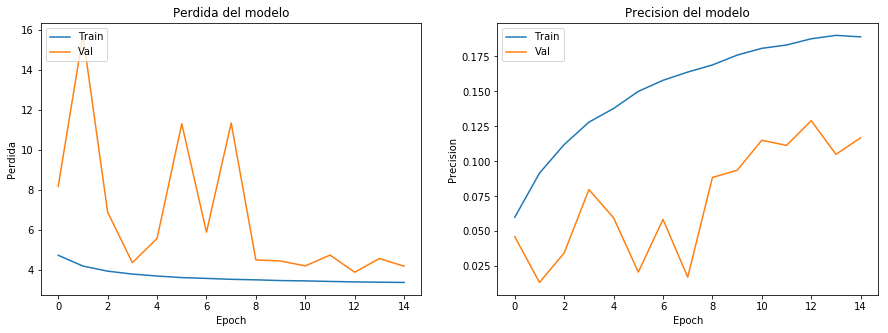

In [68]:
resumenGrafico(hist_f)

In [69]:
#LOAD PRETRAINED MODEL 
input_tensor=Input(shape=x_train.shape[1:])
modelVGG = VGG16(weights='imagenet', include_top=False,input_tensor=input_tensor )
salida_vgg = modelVGG.get_layer('block4_pool').output_shape
model = Sequential()
model.add(Conv2D(512,(3, 3),input_shape=salida_vgg[1:],activation='relu',padding='same'))
model.add(Conv2D(512,(3, 3),activation='relu',padding='same'))
model.add(Conv2D(512,(3, 3),activation='relu',padding='same'))
model.add(MaxPooling2D((2, 2),strides=(2,2)))    
##dense section
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(100, activation='softmax'))
#delete last 4 layers of VGG16 and transfer the weight to new model
modelVGG.layers.pop() #delete last maxpooling
for i in np.arange(2,-1,-1):
    last = modelVGG.layers.pop() #delete convolutional layers
    model.layers[i].set_weights(last.get_weights())
from keras.models import Model
crop_modelVGG = Model(inputs=modelVGG.input, outputs=modelVGG.layers[-1].output)
features_train = crop_modelVGG.predict(x_train)
features_test = crop_modelVGG.predict(x_test)
#train it
model.compile(optimizer=Adam(),loss='categorical_crossentropy', metrics=['accuracy'])
hist_f2=model.fit(features_train,y_train,epochs=15,batch_size=128,verbose=1,validation_data=(features_test,y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 24s 485us/step - loss: 4.3735 - acc: 0.0582 - val_loss: 10.7222 - val_acc: 0.0234
Epoch 2/15
50000/50000 [==============================] - 23s 456us/step - loss: 3.9963 - acc: 0.0967 - val_loss: 8.0622 - val_acc: 0.0255
Epoch 3/15
50000/50000 [==============================] - 23s 456us/step - loss: 3.8526 - acc: 0.1144 - val_loss: 4.4491 - val_acc: 0.0741
Epoch 4/15
50000/50000 [==============================] - 23s 455us/step - loss: 3.7696 - acc: 0.1269 - val_loss: 6.0499 - val_acc: 0.0344
Epoch 5/15
50000/50000 [==============================] - 23s 456us/step - loss: 3.7252 - acc: 0.1332 - val_loss: 8.6753 - val_acc: 0.0185
Epoch 6/15
50000/50000 [==============================] - 23s 456us/step - loss: 3.6884 - acc: 0.1394 - val_loss: 4.1356 - val_acc: 0.1045
Epoch 7/15
50000/50000 [==============================] - 23s 456us/step - loss: 3.6452 - acc: 0.1455 - val_loss: 4

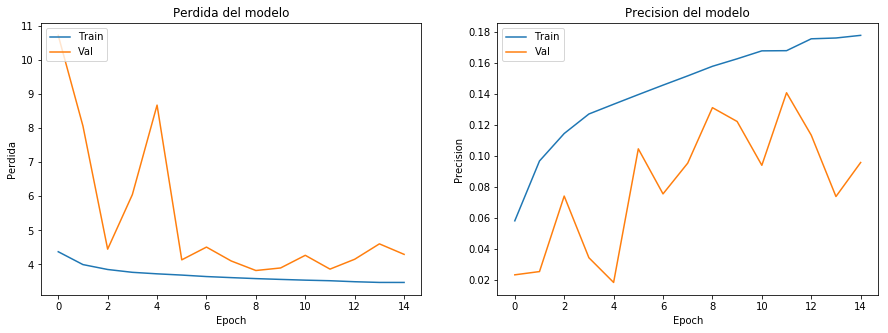

In [70]:
resumenGrafico(hist_f2)